#Автокодировщики


In [1]:
from tensorflow.keras.models import Model, Sequential # загружаем абстрактный класс базовой модели сети от кераса и последовательную модель
# Из кераса загружаем необходимые слои для нейросети
from tensorflow.keras.layers import Dense, Flatten, Reshape, Input, Conv2DTranspose, concatenate, Activation, MaxPooling2D, Conv2D, BatchNormalization
from tensorflow.keras import backend as K                     # подтягиваем базовые керасовские функции
from tensorflow.keras.optimizers import Adam                  # загружаем выбранный оптимизатор
from tensorflow.keras import utils                            # загружаем утилиты кераса
from tensorflow.keras.datasets import mnist, fashion_mnist    # загружаем готовые базы mnist
from tensorflow.keras.callbacks import LambdaCallback         # Создание собственного колбэка 

import matplotlib.pyplot as plt                 # из библиотеки для визуализации данных возьмём интерфейс для построения графиков простых функций
from tensorflow.keras.preprocessing import image              # модуль для отрисовки изображения
import numpy as np                                            # библиотека для работы с массивами данных
import pandas as pd                                           # библиотека для анализа и обработки данных
from PIL import Image                                         # модуль для отрисовки изображения
from sklearn.model_selection import train_test_split          # модуль для разбивки выборки на тренировочную/тестовую
from sklearn.preprocessing import StandardScaler              # модуль для стандартизации данных

import os, time, random
from google.colab import drive                                # модуль для работы с google диском 
import seaborn as sns
sns.set_style('darkgrid')

In [2]:
drive.mount('/content/drive/') # монтируем google диск

Mounted at /content/drive/


In [3]:
def baseAutoencoder(shape=(112,80,1)): # зададим функцию создания базового автокодировщика
    img_input = Input((shape)) # задаём входные размеры

# входные данные передаем на слой двумерной свёртки 
# затем нормализуем полученные от предыдущего слоя значения
# далее ещё слой двумерной свёртки на 64 признака
# снова нормализуем значения
# передаём на слой подвыборки, снижающий размерность поступивших на него данных
    x = Conv2D(32, (3, 3), padding='same', activation='relu')(img_input) 
    x = BatchNormalization()(x) 
    x = Conv2D(32, (3, 3), padding='same', activation='relu')(x) 
    x = BatchNormalization()(x) 
    x = MaxPooling2D()(x) 
# новый блок обработки
    x = Conv2D(64, (3, 3), padding='same', activation='relu')(x) # получаем карту признаков 64 нейрона
    x = BatchNormalization()(x)                                  # добавляем слой нормализации данных 
    x = Conv2D(64, (3, 3), padding='same', activation='relu')(x) # получаем карту признаков 64 нейрона
    x = BatchNormalization()(x)                                  # добавляем слой нормализации данных 
    z = MaxPooling2D()(x)                                        # уменьшаем размерность данных в 2 раза
    

# следующий слой увеличивает данные из "скрытого пространства" в два раза
    x = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same', 
                        activation='relu')(z) 
    x = BatchNormalization()(x) # снова нормализуем значения
    
    x = Conv2D(64, (3, 3), padding='same', activation='relu')(x)
    x = BatchNormalization()(x)
    x = Conv2D(64, (3, 3), padding='same', activation='relu')(x)
    x = BatchNormalization()(x)
    # Сжатие MaxPooling2D не применяем

# следующий слой увеличивает данные из "скрытого пространства" ещё в два раза
    x = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same', 
                        activation='relu')(x)
    x = BatchNormalization()(x)
    x = Conv2D(32, (3, 3), padding='same', activation='relu')(x)
    x = BatchNormalization()(x)
    x = Conv2D(32, (3, 3), padding='same', activation='relu')(x)
    x = BatchNormalization()(x)

# Финальный слой двумерной свертки, выдающий итоговое изображение
    x = Conv2D(shape[-1], (3, 3), activation='sigmoid', padding='same')(x)

# указываем модель (model), с оригинальным изображением на входе в сеть 
# и сжатым-разжатым на выходе из сети результатом работы
    model = Model(img_input, x) 
# собираем модель с оптимайзером Адам (шагом обучения lr) и среднеквадратичной ошибкой MSE
    model.compile(optimizer=Adam(lr=0.0001), 
                  loss='mean_squared_error') 

    return model # функция вернёт заданную модель

In [4]:
def plotImages(xTrain, pred, shape=(112, 80)): # создадим функцию для вывода изображений как картинок
  n = 5                                           # количество картинок, которые хотим показать
  plt.figure(figsize=(14, 7))                     # указываем размеры фигуры
  for i in range(n):                              # для каждой картинки из n(5)
      index = np.random.randint(0, pred.shape[0]) # startIndex - начиная с какого индекса хотим заплотить картинки
      # Показываем картинки из тестового набора
      ax = plt.subplot(2, n, i + 1)           # выведем область рисования Axes
      plt.imshow(xTrain[index].reshape(shape))  # отрисуем правильные картинки в размере 112*80      
      plt.gray()                                # выведем в черно-белом цвете
      ax.get_xaxis().set_visible(False)         # скрываем вывод координатной оси x
      ax.get_yaxis().set_visible(False)         # скрываем вывод координатной оси y

      # Показываем восстановленные картинки
      ax = plt.subplot(2, n, i + 1 + n)       # выведем область рисования Axes 
      plt.imshow(pred[index].reshape(shape))    # отрисуем обработанные сеткой    
      plt.gray()                                # выведем в черно-белом цвете
      ax.get_xaxis().set_visible(False)         # скрываем вывод координатной оси x
      ax.get_yaxis().set_visible(False)         # скрываем вывод координатной оси y
  plt.show()

In [5]:
# Функция для расчета ОШИБКИ mse
def getMSE(x1, x2):     # создадим функцию среднеквадратичной ошибки
  x1 = x1.flatten()     # сплющиваем в одномерный вектор
  x2 = x2.flatten()     # сплющиваем в одномерный вектор
  delta = x1 - x2       # находим разницу
  return sum(delta ** 2) / len(delta) # и возвращаем сумму квадратов разницы, делённую на длину разницы

In [6]:
# Зададим пару массивов и проверим работу функции
x1 = np.array([1, 1, 1])    # создаем первый массив
x2 = np.array([1, 1, 1])    # создаем второй массив
print(getMSE(x1,x2))        # выведем ошибку полученную нашей функцией

0.0


In [7]:
# Зададим пару массивов и проверим работу функции
x1 = np.array([1, 1, 1, 1]) # создаем первый массив
x2 = np.array([1, 1, 0, 0]) # создаем второй массив
print(getMSE(x1,x2))        # выведем ошибку полученную нашей функцией

0.5


# Эксперимент 1 на базе MNIST



In [8]:
(xTrainMnist, yTrainMnist), (xTestMnist, yTestMnist) = mnist.load_data() # загружаем данные из базы с разбивкой на train/test
xTrainMnist = xTrainMnist.astype('float32')/255     # представляем в виде значений от 0 до 1
xTrainMnist = xTrainMnist.reshape(-1, 28, 28, 1)    # меняем форму, приводим к нужным нам размерам
xTestMnist = xTestMnist.astype('float32')/255       # представляем в виде значений от 0 до 1
xTestMnist = xTestMnist.reshape(-1, 28, 28, 1)      # меняем форму, приводим к нужным нам размерам

11490434/11490434 [==============================] - 0s 0us/step


In [9]:
xTrainMnist.shape # Отобразим размерность массива xTrainMnist

(60000, 28, 28, 1)

In [10]:
modelAutoMnist = baseAutoencoder((28,28,1)) # создаем автокодировщик

/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [11]:
modelAutoMnist.summary()   # Смотрим визуально созданную модель

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 28, 28, 1)]       0         
                                                                 
 conv2d (Conv2D)             (None, 28, 28, 32)        320       
                                                                 
 batch_normalization (BatchN  (None, 28, 28, 32)       128       
 ormalization)                                                   
                                                                 
 conv2d_1 (Conv2D)           (None, 28, 28, 32)        9248      
                                                                 
 batch_normalization_1 (Batc  (None, 28, 28, 32)       128       
 hNormalization)                                                 
                                                                 
 max_pooling2d (MaxPooling2D  (None, 14, 14, 32)       0     

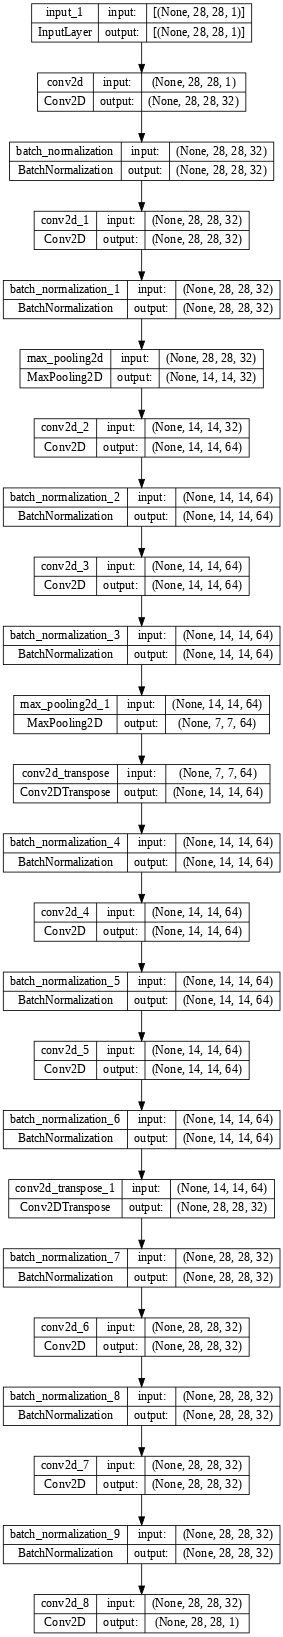

In [12]:
# Второй вариант отображения модели 
utils.plot_model(modelAutoMnist, dpi=60, show_shapes=True)

In [13]:
# Обучаем модель автокодировщика
                # Одни и теже данные для обучения для тренировки модели.
history = modelAutoMnist.fit(xTrainMnist, xTrainMnist,      
                             epochs=100, batch_size=256, 
                             validation_data = (xTestMnist, xTestMnist)) 
                # Проверочные данные отличаются от тренировочных но не между собой

Epoch 1/100
235/235 [==============================] - 21s 50ms/step - loss: 0.0790 - val_loss: 0.0942
Epoch 2/100
235/235 [==============================] - 12s 51ms/step - loss: 0.0164 - val_loss: 0.0177
Epoch 3/100
235/235 [==============================] - 11s 49ms/step - loss: 0.0091 - val_loss: 0.0068
Epoch 4/100
235/235 [==============================] - 11s 47ms/step - loss: 0.0064 - val_loss: 0.0055
Epoch 5/100
235/235 [==============================] - 11s 47ms/step - loss: 0.0050 - val_loss: 0.0045
Epoch 6/100
235/235 [==============================] - 11s 47ms/step - loss: 0.0041 - val_loss: 0.0038
Epoch 7/100
235/235 [==============================] - 11s 47ms/step - loss: 0.0035 - val_loss: 0.0033
Epoch 8/100
235/235 [==============================] - 11s 47ms/step - loss: 0.0031 - val_loss: 0.0028
Epoch 9/100
235/235 [==============================] - 11s 48ms/step - loss: 0.0027 - val_loss: 0.0026
Epoch 10/100
235/235 [==============================] - 11s 48ms/step - l

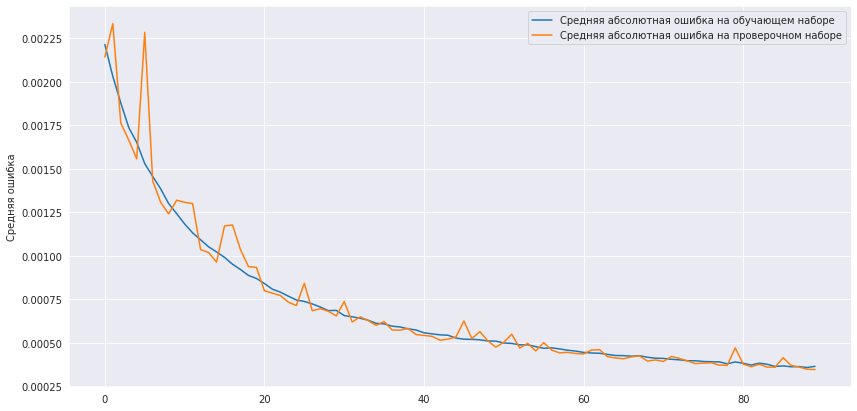

In [14]:
#Выводим графики
plt.figure(figsize=(14,7))
plt.plot(history.history['loss'][10:], 
         label='Средняя абсолютная ошибка на обучающем наборе')
plt.plot(history.history['val_loss'][10:], 
         label='Средняя абсолютная ошибка на проверочном наборе')
plt.ylabel('Средняя ошибка')
plt.legend()
plt.show()

In [ ]:
way = '/content/drive/MyDrive/Colab Notebooks/150 Автокодировщики/'
modelAutoMnist.save_weights(way+'modelAutoMnist.h5') # Для сохранения весов модели
modelAutoMnist.load_weights(way+'modelAutoMnist.h5') # Для загрузки весов модели

In [15]:
# Получаем результат работы модели на тестовой выборке
predMnistTest = modelAutoMnist.predict(xTestMnist)  
# представляем в виде значений от 0 до 255
predMnistTest = predMnistTest * 255 
# устанавливаем 8-битовый тип
predMnistTest = predMnistTest.astype('uint8')

313/313 [==============================] - 1s 3ms/step


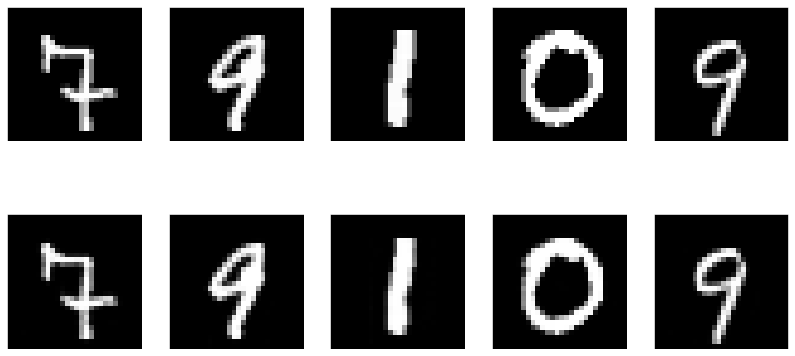

In [19]:
plotImages(xTestMnist, predMnistTest, shape=(28,28)) # покажем исходные и восстановленные картинки

In [17]:
# Получаем результат работы модели на обучающей выборке
predMnistTrain = modelAutoMnist.predict(xTrainMnist)
# представляем в виде значений от 0 до 255
predMnistTrain = predMnistTrain * 255
# устанавливаем 8-битовый тип
predMnistTrain = predMnistTrain.astype('uint8')

1875/1875 [==============================] - 6s 3ms/step


In [18]:
# Возьмем среднеквадратичную ошибку от правильной картинки и восстановленной (обучающая выборка)
err1 = [getMSE(xTrainMnist[i], predMnistTrain[i] / 255) for i in range(len(predMnistTrain))]

# Возьмем среднеквадратичную ошибку от правильной картинки и восстановленной (тестовая выборка)
err2 = [getMSE(xTestMnist[i], predMnistTest[i] / 255) for i in range(len(predMnistTest))]

print("Средняя ошибка на обучающем наборе MNIST:", sum(err1) / xTrainMnist.shape[0])
print("Средняя ошибка на тестовом наборе MNIST:", sum(err2) /xTestMnist.shape[0] ) 

Средняя ошибка на обучающем наборе MNIST: 0.0003336072957843894
Средняя ошибка на тестовом наборе MNIST: 0.0003440793707276749
